# 🧠 Problem Formulation

This experiment aims to compare the performance of two types of binary classifiers, **Type 1 (Strategic)** and **Type 2 (Non-Strategic)**, under varying degrees of data observability. The core problem is to predict a binary label \( Y \in \{-1, +1\} \) based on a 2D feature vector \( X \), with the potential availability of binary side information \( Z \in \{-1, +1\} \).

**Key characteristics of the setup are:**
- **Fixed Data Distribution:** The joint probability of \( (Y, Z) \) and the conditional distribution of \( X \) given \( (Y, Z) \) are fixed. Specifically, \( X \) is drawn from one of four Gaussian distributions whose means are located on the unit circle, determined by the values of \( Y \) and \( Z \).
- **Strategic Revelation:** A "preference" function \( u(x) \) determines an agent's desired outcome. In the strategic setting, the agent may choose to reveal or hide the side information \( Z \) based on whether it aligns with their preference.
- **Variable Observation Probability (\( p_o \)):** The central variable in this experiment is \( p_o \), the probability that the side information \( Z \) is observed. We will vary \( p_o \) from 0 to 1.

**Objective:**
The main goal is to analyze and compare the **risk (expected 0-1 loss)** of the Strategic and Non-Strategic classifiers as a function of \( p_o \). This will help us understand how the assumption of strategic behavior impacts model performance compared to a standard model that assumes random data observation. The comparison will be visualized by plotting the risks of both classifiers against the different values of \( p_o \).

# 🧭 Proposed Solution

Our solution involves a computational experiment to simulate and compare the two classifier types. The overall strategy is to implement the data generation process, the models, the training, and the evaluation as described in the problem formulation.

The workflow is broken down into the following phases:

1.  **Setup and Configuration:** We will start by defining all the fixed parameters of the experiment, such as the means and covariance of the Gaussian distributions, the parameters of the preference function, the temperature for the soft-min/max functions, and the range of \( p_o \) values to be tested.

2.  **Implementation of Core Components:**
    *   **Data Generation:** A function will be created to generate datasets according to the specified distributions. This function will also handle the logic for partitioning the data based on the observation probability \( p_o \).
    *   **Model Architecture:** We will implement the hypothesis functions \( f_w \) and \( g_{w,\lambda} \). A simple linear model will be used for \( f_w \). The strategic and non-strategic scoring functions will also be implemented.
    *   **Training and Evaluation:** We will define the logistic loss function and an optimization loop (using a standard optimizer like Adam) to train the models. A separate function will be used to evaluate the models' performance based on the 0-1 loss (risk).

3.  **Experiment Execution:**
    *   A main loop will iterate through the different values of \( p_o \).
    *   In each iteration, we will generate new training and test datasets.
    *   Both the Type 1 (Strategic) and Type 2 (Non-Strategic) classifiers will be trained on the training data.
    *   The trained classifiers will then be evaluated on the (unbiased) test data to compute their respective risks.

4.  **Analysis and Visualization:**
    *   The risks of both classifiers for each \( p_o \) will be collected.
    *   Finally, we will generate a plot showing the risk of each classifier as a function of \( p_o \). This visualization will be the primary output of our experiment, allowing for a direct comparison of the two approaches.

This structured approach ensures that our experiment is reproducible and that the results are clearly interpretable in the context of the problem.

# ⚙️ Implementation

### ⚙️ Block 0: Configuration Block

This block contains all the configurable parameters for the experiment. Centralizing these parameters makes the notebook easier to understand, reuse, and modify. We define hyperparameters for the models, data generation settings, and other constants.

In [1]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Data Generation Parameters ---
N_SAMPLES_TRAIN = 2000
N_SAMPLES_TEST = 1000
P_O_VALUES = np.arange(0, 1.1, 0.1)

# Joint distribution P(Y, Z)
P_YZ = {
    (1, 1): 0.4,
    (1, -1): 0.1,
    (-1, 1): 0.1,
    (-1, -1): 0.4
}

# Conditional means mu_{y,z}
MEANS = {
    (1, 1): torch.tensor([1.0, 0.0]),
    (1, -1): torch.tensor([0.0, 1.0]),
    (-1, 1): torch.tensor([-1.0, 0.0]),
    (-1, -1): torch.tensor([0.0, -1.0])
}

# Conditional covariance
COV_MATRIX = torch.eye(2)

# --- Model Parameters ---
ALPHA = 1.0  # For preference function u(x)
TAU = 0.5    # Temperature for soft-min/max

# --- Training Hyperparameters ---
LEARNING_RATE = 0.01
N_EPOCHS = 100
BATCH_SIZE = 64

### 📦 Dataset

This section handles the data generation process. We create a function to sample data points according to the specified distributions. This includes generating the features \(X\), the label \(Y\), the side information \(Z\), and the preference \(u(x)\). The function also simulates the two different data observation settings: strategic and non-strategic.

In [2]:
def generate_data(n_samples, p_o, strategic):
    """
    Generates a dataset for the experiment.
    
    Args:
        n_samples (int): The number of samples to generate.
        p_o (float): The probability of observing Z.
        strategic (bool): If True, simulates strategic revelation. 
                          If False, simulates random revelation.

    Returns:
        A tuple of torch tensors: (X, Y, Z, U, Z_observed_mask)
    """
    # Sample (Y, Z) pairs from the joint distribution
    yz_pairs = list(P_YZ.keys())
    probabilities = list(P_YZ.values())
    indices = np.random.choice(len(yz_pairs), size=n_samples, p=probabilities)
    yz = torch.tensor([yz_pairs[i] for i in indices], dtype=torch.float32)
    Y = yz[:, 0]
    Z = yz[:, 1]

    # Sample X from the conditional Gaussian distribution
    X = torch.zeros(n_samples, 2)
    for i in range(n_samples):
        mean = MEANS[(Y[i].item(), Z[i].item())]
        X[i] = torch.distributions.MultivariateNormal(mean, COV_MATRIX).sample()

    # Compute the preference function U
    U = torch.sign(torch.sin(ALPHA * (X[:, 0] + X[:, 1])))
    U[U == 0] = 1 # Set sign(0) to 1

    # Determine which Z values are observed
    if strategic:
        # Strategic setting: reveal Z if it aligns with preference U
        z_observed_mask = (Z == U)
    else:
        # Non-strategic setting: reveal Z with probability p_o
        z_observed_mask = (torch.rand(n_samples) < p_o)

    return X, Y, Z, U, z_observed_mask

### 🧱 Architecture

Here, we define the architecture of our classifiers. This includes the linear model for \(f_w\), the combined model \(g_{w,\lambda}\), and the scoring functions for both the strategic and non-strategic settings. We encapsulate these into a single PyTorch module for easier management of parameters and computations.

In [3]:
class StrategicClassifier(torch.nn.Module):
    def __init__(self, strategic_setting):
        super().__init__()
        self.strategic_setting = strategic_setting
        # Parameters for f_w(x, z) = w_0 + w_1*x_1 + w_2*x_2 + w_3*z
        self.w = torch.nn.Parameter(torch.randn(4))
        # Parameter lambda for g_{w,lambda}
        self.log_lambda_sq = torch.nn.Parameter(torch.tensor(0.0)) # log(lambda^2) for stability

    def f_w(self, x, z):
        """Computes the score f_w(x, z)."""
        return self.w[0] + self.w[1] * x[:, 0] + self.w[2] * x[:, 1] + self.w[3] * z

    def g_w_lambda(self, x):
        """Computes the score g_{w,lambda}(x)."""
        lambda_sq = torch.exp(self.log_lambda_sq)
        weight_neg = lambda_sq / (1 + lambda_sq)
        weight_pos = 1 / (1 + lambda_sq)
        return weight_neg * self.f_w(x, -torch.ones(x.shape[0])) + \
               weight_pos * self.f_w(x, torch.ones(x.shape[0]))

    def forward(self, x, z, u, z_observed_mask):
        """Computes the final score for prediction."""
        score_g = self.g_w_lambda(x)
        
        # For samples where Z is not observed, the score is g
        final_score = score_g.clone()

        # For samples where Z is observed
        if torch.any(z_observed_mask):
            x_obs = x[z_observed_mask]
            z_obs = z[z_observed_mask]
            u_obs = u[z_observed_mask]
            
            score_f = self.f_w(x_obs, z_obs)

            if self.strategic_setting:
                score_g_obs = score_g[z_observed_mask]
                
                # Soft-max for u = +1
                mask_u_pos = (u_obs == 1)
                if torch.any(mask_u_pos):
                    s_g = score_g_obs[mask_u_pos]
                    s_f = score_f[mask_u_pos]
                    exp_g = torch.exp(s_g / TAU)
                    exp_f = torch.exp(s_f / TAU)
                    final_score[z_observed_mask][mask_u_pos] = (s_g * exp_g + s_f * exp_f) / (exp_g + exp_f)

                # Soft-min for u = -1
                mask_u_neg = (u_obs == -1)
                if torch.any(mask_u_neg):
                    s_g = score_g_obs[mask_u_neg]
                    s_f = score_f[mask_u_neg]
                    exp_g = torch.exp(-s_g / TAU)
                    exp_f = torch.exp(-s_f / TAU)
                    final_score[z_observed_mask][mask_u_neg] = (s_g * exp_g + s_f * exp_f) / (exp_g + exp_f)
            else: # Non-strategic setting
                final_score[z_observed_mask] = score_f
                
        return final_score

### 🧪 Experiment

This section contains the code for running the experiment. We define functions to train the model and to evaluate its performance. The main loop iterates through the different values of \(p_o\), trains both types of classifiers, and records their risks.

In [4]:
def train_model(model, X, Y, Z, U, z_observed_mask):
    """Trains the classifier."""
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    dataset = torch.utils.data.TensorDataset(X, Y, Z, U, z_observed_mask)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(N_EPOCHS):
        for x_batch, y_batch, z_batch, u_batch, z_obs_mask_batch in dataloader:
            optimizer.zero_grad()
            scores = model(x_batch, z_batch, u_batch, z_obs_mask_batch)
            loss = loss_fn(scores, (y_batch + 1) / 2) # BCEWithLogitsLoss expects labels in [0, 1]
            loss.backward()
            optimizer.step()

def evaluate_model(model, X_test, Y_test, Z_test, U_test):
    """Evaluates the model and returns the risk (0-1 loss)."""
    with torch.no_grad():
        # In evaluation, we assume Z is always observed (unbiased test set)
        z_observed_mask_test = torch.ones(X_test.shape[0], dtype=torch.bool)
        scores = model(X_test, Z_test, U_test, z_observed_mask_test)
        predictions = torch.sign(scores)
        risk = torch.mean((predictions != Y_test).float())
    return risk.item()

# --- Main Experiment Loop ---
risks_strategic = []
risks_non_strategic = []

for p_o in P_O_VALUES:
    print(f"Running experiment for p_o = {p_o:.1f}")

    # --- Type 1: Strategic Classifier ---
    # Train on strategically revealed data
    X_train, Y_train, Z_train, U_train, z_obs_mask_train = generate_data(N_SAMPLES_TRAIN, p_o, strategic=True)
    model_strategic = StrategicClassifier(strategic_setting=True)
    train_model(model_strategic, X_train, Y_train, Z_train, U_train, z_obs_mask_train)
    
    # Evaluate on unbiased test data
    X_test, Y_test, Z_test, U_test, _ = generate_data(N_SAMPLES_TEST, p_o=1.0, strategic=False)
    risk_strategic = evaluate_model(model_strategic, X_test, Y_test, Z_test, U_test)
    risks_strategic.append(risk_strategic)

    # --- Type 2: Non-Strategic Classifier ---
    # Train on randomly revealed data
    X_train, Y_train, Z_train, U_train, z_obs_mask_train = generate_data(N_SAMPLES_TRAIN, p_o, strategic=False)
    model_non_strategic = StrategicClassifier(strategic_setting=False)
    train_model(model_non_strategic, X_train, Y_train, Z_train, U_train, z_obs_mask_train)

    # Evaluate on unbiased test data
    risk_non_strategic = evaluate_model(model_non_strategic, X_test, Y_test, Z_test, U_test)
    risks_non_strategic.append(risk_non_strategic)

Running experiment for p_o = 0.0
Running experiment for p_o = 0.1
Running experiment for p_o = 0.2
Running experiment for p_o = 0.3
Running experiment for p_o = 0.4
Running experiment for p_o = 0.5
Running experiment for p_o = 0.6
Running experiment for p_o = 0.7
Running experiment for p_o = 0.8
Running experiment for p_o = 0.9
Running experiment for p_o = 1.0


### 🔍 Inspection & Visualization Block

In this block, we visualize the results of our experiment. We will plot the risks of the Type 1 (Strategic) and Type 2 (Non-Strategic) classifiers as a function of the observation probability \( p_o \). This plot is the key output of our analysis, as it allows for a direct comparison of the two models under different conditions.

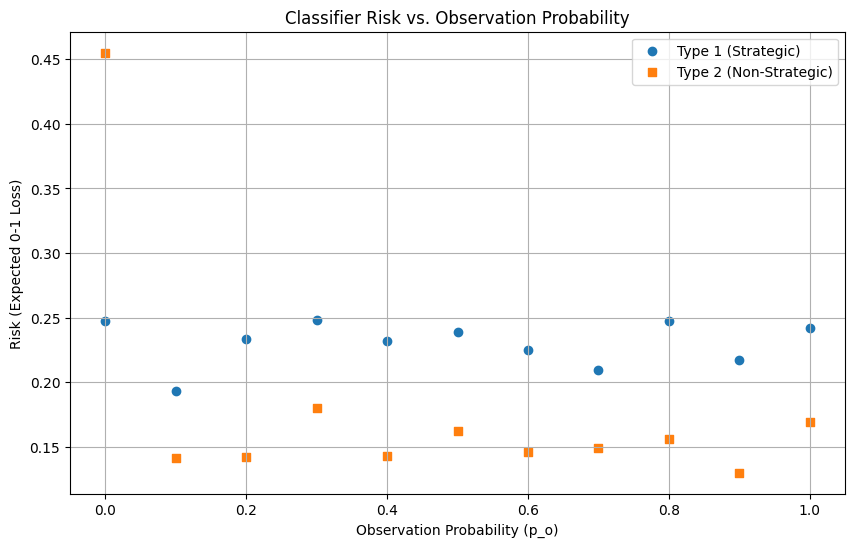

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(P_O_VALUES, risks_strategic, marker='o', label='Type 1 (Strategic)')
plt.scatter(P_O_VALUES, risks_non_strategic, marker='s', label='Type 2 (Non-Strategic)')
plt.xlabel('Observation Probability (p_o)')
plt.ylabel('Risk (Expected 0-1 Loss)')
plt.title('Classifier Risk vs. Observation Probability')
plt.legend()
plt.grid(True)
plt.show()